In [1]:
!pip install networkx 

In [2]:
import networkx as nx

In [3]:
import matplotlib.pyplot as plt

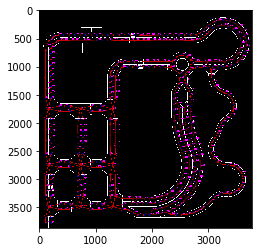

In [4]:
G = nx.read_graphml('comp_track.graphml')
import cv2
img=cv2.imread("Competition_track.png")
plt.imshow(img)

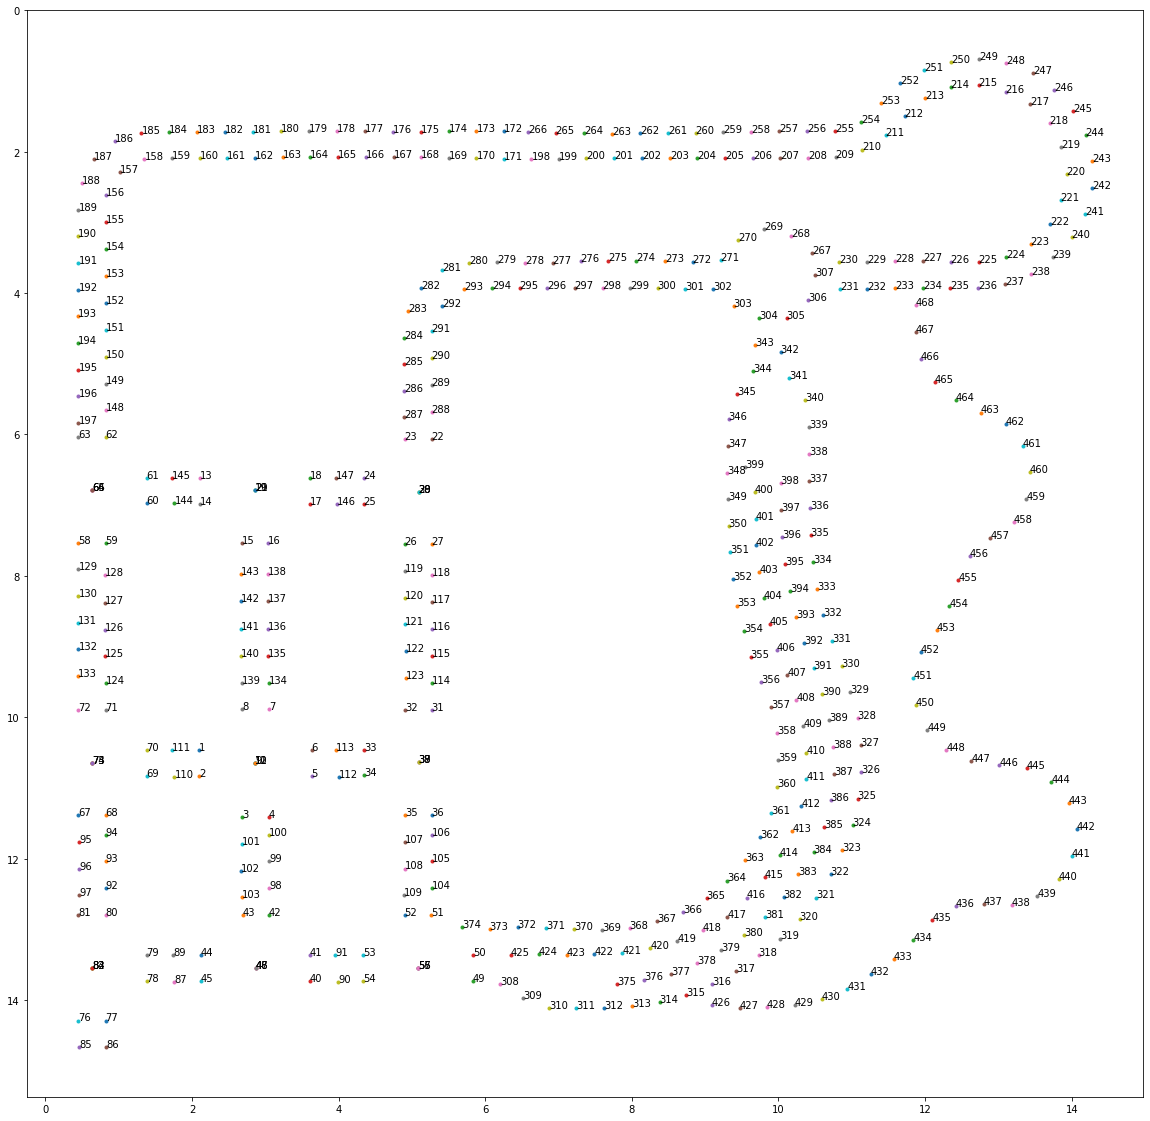

In [5]:
plt.figure(figsize=(20,20))
for node,data in G.nodes(data=True):
    plt.plot(data['x'],data['y'],'.')
    ax = plt.gca()
    ax.annotate(str(node), (data['x'],data['y'])) 

ax = plt.gca()
ax.invert_yaxis()
# plt.legend()
# plt.show()

In [508]:
for i in G.neighbors('24'):
    print(i)

103


In [6]:
import heapq
def dijkstra(G, start, target):
    d = {start: 0}
    parent = {start: None}
    pq = [(0, start)]
    visited = set()
    while pq:
        du, u = heapq.heappop(pq)
        if u in visited:
            continue
        if u == target:
            break
        visited.add(u)
        for v  in G.adj[u]:
            if v not in d or d[v] > du + 1:
                d[v] = du + 1
                parent[v] = u
                heapq.heappush(pq, (d[v], v))

    fp = [target]
    tg = target

    while tg != start:
        fp.insert(0, parent[tg])
        tg = parent[tg]

    return fp

In [7]:
path_list=dijkstra(G,'86','54')

In [10]:
G["86"]

AtlasView({'77': {'dotted': False}})

In [11]:
node_dict=G.nodes(data=True)

In [12]:
node_dict['86']

{'x': 0.83, 'y': 14.67}

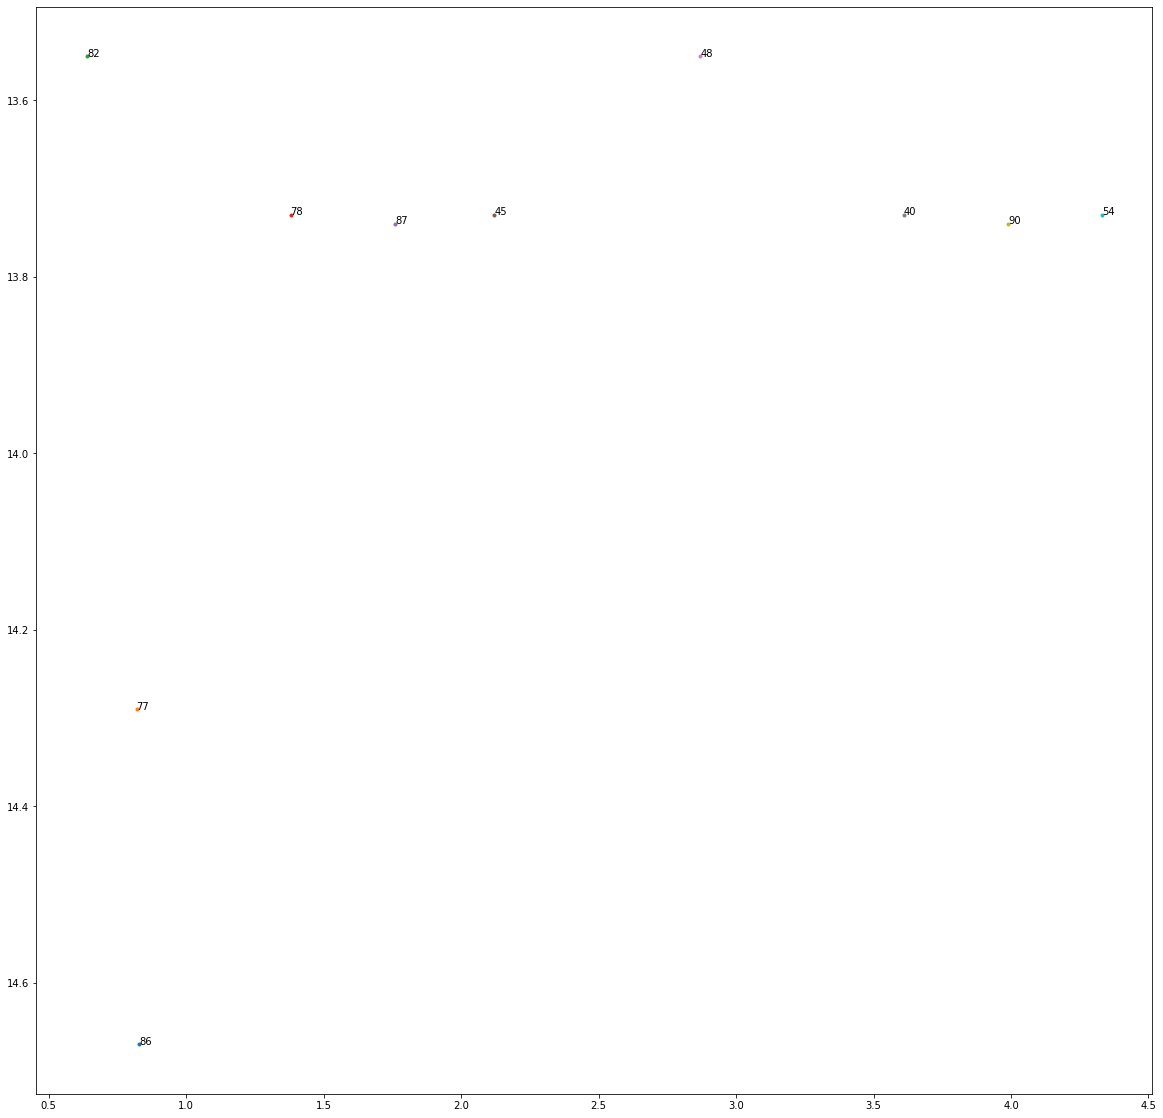

In [14]:
coord_list=[]
plt.figure(figsize=(20,20))
for i in path_list:
    data=node_dict[i]
    plt.plot(data['x'],data['y'],'.')
    coord_list.append((data['x'],data['y']))
    ax = plt.gca()
    ax.annotate(str(i), (data['x'],data['y'])) 

# plt.xlim(0,6)
# plt.ylim(0,6)


ax = plt.gca()
ax.invert_yaxis()

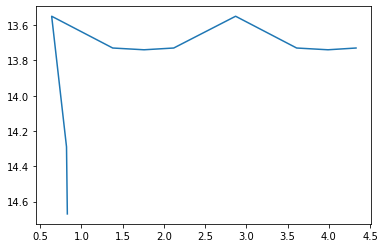

In [15]:
x, y = zip(*coord_list)
plt.plot(x,y)
ax = plt.gca()
ax.invert_yaxis()

In [587]:
## Global polyfit doesnt work as expected

In [588]:
import numpy as np
z = np.polyfit(x, y, 6)
p=np.poly1d(z)

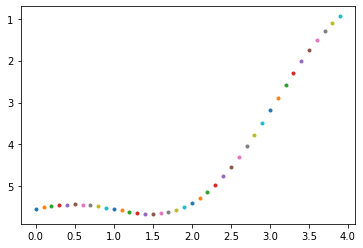

In [589]:
xp=[]
yp=[]
for xx in range(0,40):
    num=xx/10
    xp.append(num)
    yy=p(num)
    yp.append(yy)
    plt.plot(num,yy,'.')
ax = plt.gca()
ax.invert_yaxis()

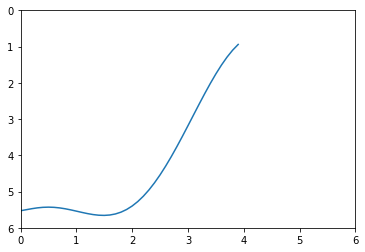

In [590]:
plt.plot(xp,yp)
plt.xlim(0,6)
plt.ylim(0,6)


ax = plt.gca()
ax.invert_yaxis()

In [591]:
# local poly fitting for adjacent node
print(len(path_list))

24
